In [18]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk
import sklearn.model_selection
import albumentations as A
import cv2
import itertools
import os
import time
from pathlib import Path
from tqdm.notebook import tqdm
import math
import pickle
from scipy import ndimage

# pytorch stuff
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader

# need for AMP
from torch.cuda.amp import autocast
from torch.cuda.amp import GradScaler

torch.manual_seed(3)
from tqdm.notebook import tqdm

#https://github.com/mcordts/cityscapesScripts

## Data

1. To get the data go to https://www.cityscapes-dataset.com/ and register. Then download these files:
`gtFine_trainvaltest.zip` and `leftImg8bit_trainvaltest.zip`. Put the data in your gpu and unzip.

2. Go to directory `utils` open the file `preprocess_data.py` and replace the following paths
`cityscapes_data_path` and `cityscapes_meta_path`.

3. Run `python preprocess_data.py`

In [19]:
PATH = Path('/data2/yinterian/cityscapes/')

In [20]:
def read_image(path):
    im = cv2.imread(str(path))
    return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

In [21]:
list((PATH/"leftImg8bit/train/zurich").iterdir())[:10] 

[PosixPath('/data2/yinterian/cityscapes/leftImg8bit/train/zurich/zurich_000051_000019_leftImg8bit.png'),
 PosixPath('/data2/yinterian/cityscapes/leftImg8bit/train/zurich/zurich_000092_000019_leftImg8bit.png'),
 PosixPath('/data2/yinterian/cityscapes/leftImg8bit/train/zurich/zurich_000117_000019_leftImg8bit.png'),
 PosixPath('/data2/yinterian/cityscapes/leftImg8bit/train/zurich/zurich_000003_000019_leftImg8bit.png'),
 PosixPath('/data2/yinterian/cityscapes/leftImg8bit/train/zurich/zurich_000071_000019_leftImg8bit.png'),
 PosixPath('/data2/yinterian/cityscapes/leftImg8bit/train/zurich/zurich_000040_000019_leftImg8bit.png'),
 PosixPath('/data2/yinterian/cityscapes/leftImg8bit/train/zurich/zurich_000121_000019_leftImg8bit.png'),
 PosixPath('/data2/yinterian/cityscapes/leftImg8bit/train/zurich/zurich_000048_000019_leftImg8bit.png'),
 PosixPath('/data2/yinterian/cityscapes/leftImg8bit/train/zurich/zurich_000045_000019_leftImg8bit.png'),
 PosixPath('/data2/yinterian/cityscapes/leftImg8bit/tra

(<matplotlib.image.AxesImage at 0x7f7cde917400>, (1024, 2048, 3))

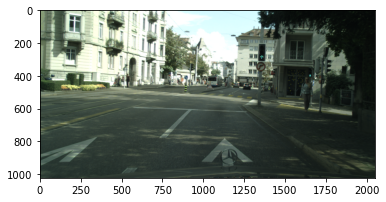

In [22]:
path = PATH/"leftImg8bit/train/zurich/zurich_000051_000019_leftImg8bit.png"
im1 = read_image(path)
plt.imshow(im1), im1.shape

In [23]:
list((PATH/"meta").iterdir())[:10] 

[PosixPath('/data2/yinterian/cityscapes/meta/label_imgs'),
 PosixPath('/data2/yinterian/cityscapes/meta/class_weights.pkl')]

In [24]:
list((PATH/"meta/label_imgs").iterdir())[:10] 

[PosixPath('/data2/yinterian/cityscapes/meta/label_imgs/bremen_000260_000019.png'),
 PosixPath('/data2/yinterian/cityscapes/meta/label_imgs/weimar_000005_000019.png'),
 PosixPath('/data2/yinterian/cityscapes/meta/label_imgs/ulm_000048_000019.png'),
 PosixPath('/data2/yinterian/cityscapes/meta/label_imgs/stuttgart_000139_000019.png'),
 PosixPath('/data2/yinterian/cityscapes/meta/label_imgs/cologne_000012_000019.png'),
 PosixPath('/data2/yinterian/cityscapes/meta/label_imgs/krefeld_000000_022162.png'),
 PosixPath('/data2/yinterian/cityscapes/meta/label_imgs/hanover_000000_030781.png'),
 PosixPath('/data2/yinterian/cityscapes/meta/label_imgs/darmstadt_000027_000019.png'),
 PosixPath('/data2/yinterian/cityscapes/meta/label_imgs/hanover_000000_045841.png'),
 PosixPath('/data2/yinterian/cityscapes/meta/label_imgs/tubingen_000090_000019.png')]

(<matplotlib.image.AxesImage at 0x7f7cde8e6d60>, (1024, 2048, 3))

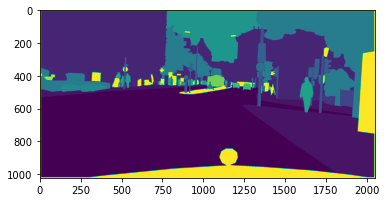

In [25]:
path = PATH/"meta/label_imgs/zurich_000051_000019.png"
label_img = read_image(path)
plt.imshow(label_img[:,:,0]), label_img.shape

In [26]:
(label_img[:,:,0] == label_img[:,:,2]).sum(), 1024*2048

(2097152, 2097152)

In [27]:
# 20 classes
label_img.reshape(-1).min(), label_img.reshape(-1).max()

(0, 19)

## Resizing images
Note that this should be done before training and not `during` training. 

In [28]:
def resize_image(img, img_h=532, img_w=1064):
    img = cv2.resize(img, (img_w, img_h), interpolation=cv2.INTER_NEAREST) # (shape: (512, 1024, 3))
    return img

In [29]:
x = resize_image(im1, img_h=266, img_w=532)
y = resize_image(label_img[:,:,0], img_h=266, img_w=532)

In [30]:
x.shape, y.shape

((266, 532, 3), (266, 532))

In [31]:
def plot_two_imgs(im1, im2):
    f = plt.figure(figsize=(12,8))
    f.add_subplot(1,2, 1)
    plt.imshow(im1)
    f.add_subplot(1,2, 2)
    plt.imshow(im2)

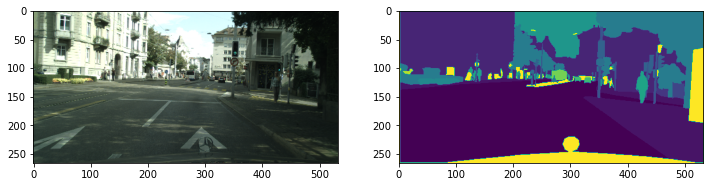

In [32]:
plot_two_imgs(x, y)

In [33]:
def resize_all_imgs(old_folder, new_folder, img_h=266, img_w=532):
    files = [f for f in old_folder.rglob("*.png")]
    for path in files:
        im = read_image(path)
        im2 = resize_image(im, img_h=img_h, img_w=img_w)
        new_path = new_folder/path.name
        cv2.imwrite(str(new_path), im2)

In [34]:
def create_img_dirs(img_h=266, img_w=532):
    imgs_dir = PATH/"imgs_{1}_{2}".format(PATH,img_h, img_w)
    for folder in ["train", "val", "test"]:
        (imgs_dir/folder).mkdir(parents=True, exist_ok=True)
        print(imgs_dir/folder)
        resize_all_imgs(PATH/"leftImg8bit"/folder, imgs_dir/folder, img_h=266, img_w=532)
    
    (imgs_dir/"labels").mkdir(parents=True, exist_ok=True)
    resize_all_imgs(PATH/"meta", imgs_dir/"labels")  

In [18]:
#create_img_dirs()

## albumentations for data augmentation 

See other tranformations here: <br>
`https://albumentations.ai/docs/api_reference/augmentations/transforms/` <br>
`https://github.com/albumentations-team/albumentations`

In [38]:
crop = (512, 256)
transformImg = A.Compose([A.RandomCrop(width=crop[0],height=crop[1]),
                          A.HorizontalFlip(p=.5),
                          A.VerticalFlip(p=.5),
                          A.Rotate(limit = 10, border_mode = cv2.BORDER_REFLECT, value = 0.0, p = .75),
                          A.GridDistortion(border_mode=cv2.BORDER_REFLECT, value=0.0, p=0.75)])          

In [39]:
centercrop = A.CenterCrop(width=crop[0],height=crop[1])

In [40]:
path = PATH/"imgs_266_532/train/zurich_000051_000019_leftImg8bit.png"
x = read_image(path)
path = PATH/"imgs_266_532/labels/zurich_000051_000019.png"
y = read_image(path)

In [45]:
transformed = transformImg(image=x, mask=y[:,:,0]) 
img = transformed['image']
mask = transformed['mask']

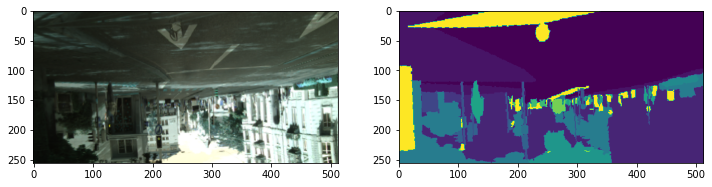

In [42]:
plot_two_imgs(img, mask)

In [43]:
transformed = centercrop(image=x, mask=y) 
img = transformed['image']
mask = transformed['mask']

(<matplotlib.image.AxesImage at 0x7f7cde749a30>, (256, 512, 3))

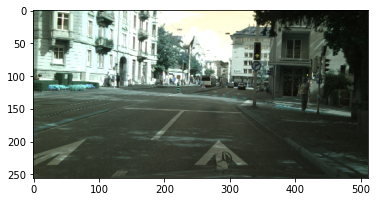

In [44]:
plt.imshow(img), img.shape

## Dataset

In [46]:
class CityScapesDataset(Dataset):
    def __init__(self, data_path, folder, transform=True, crop = (512, 256)):
        """data_path = PATH/"imgs_266_532"
           folder is in [val, train, test]
           trasform should be True for train
        """
        self.transform = transform
        self.imgs_files = [f for f in (data_path/folder).glob('*.png')]
        self.label_names = [(f.name).split("_leftImg8bit.png")[0] + ".png" for f in self.imgs_files]
        self.labels_files = [data_path/"labels"/f for f in self.label_names] 
        
        self.train_transforms = A.Compose([
            A.HorizontalFlip(p=.5),
            A.VerticalFlip(p=.5),
            A.Rotate(limit = 10, border_mode = cv2.BORDER_REFLECT, value = 0.0, p = .75),
            A.GridDistortion(border_mode=cv2.BORDER_REFLECT, value=0.0, p=0.75),
            A.RandomCrop(width=crop[0],height=crop[1])]) 
        
        self.val_transforms = A.CenterCrop(width=crop[0],height=crop[1])
        
    def __getitem__(self, index):
        im_path = self.imgs_files[index]
        label_path = self.labels_files[index]
        im = read_image(im_path)
        label = read_image(label_path)
        
        if self.transform:
            transformed = self.train_transforms(image=im, mask=label[:,:,0])
        else:
            transformed = self.val_transforms(image=im, mask=label[:,:,0])
        
        x = transformed['image']/255.
        y = transformed['mask']
        return np.rollaxis(x, 2), y
            
        
    def __len__(self):
        return len(self.imgs_files)

In [47]:
ds_train = CityScapesDataset(PATH/"imgs_266_532/", "train")
ds_val = CityScapesDataset(PATH/"imgs_266_532/", "val",  transform=False)

In [48]:
x, y = ds_train[0]
x.shape, y.shape

((3, 256, 512), (256, 512))

In [49]:
x, y = ds_val[0]
x.shape, y.shape

((3, 256, 512), (256, 512))

In [50]:
len(ds_train), len(ds_val)

(2975, 500)

In [51]:
dl_train = DataLoader(ds_train, batch_size=3, shuffle=True, num_workers=1)
dl_val = DataLoader(ds_val, batch_size=3, shuffle=False, num_workers=1)

## Basic UNet model

In [32]:
# basic unet with batch normalization
f_size = 7
padding = (int((f_size-1)/2),int((f_size-1)/2))
chs = [32, 64, 128, 256, 512] #, 1024]

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        self.relu = nn.ReLU()
        self.conv1 = nn.Conv2d(in_channels, out_channels, f_size, padding=padding)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, f_size, padding=padding)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        return x

    
class unet(nn.Module):
    
    def __init__(self):
        
        super().__init__()
        # pooling
        self.pool = nn.MaxPool2d(2,2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        
        # ENCODER
        self.conv00 = ConvBlock(3, 32)
        self.conv10 = ConvBlock(32, 64)
        self.conv20 = ConvBlock(64, 128)
        self.conv30 = ConvBlock(128, 256)
        self.conv40 = ConvBlock(256, 512)
        
        # DECODER
        self.upconv31 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.conv31 = ConvBlock(2*256, 256)
        self.upconv22 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.conv22 = ConvBlock(2*128, 128)
        self.upconv13 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.conv13 = ConvBlock(2*64, 64)
        self.upconv04 = nn.ConvTranspose2d(64, 32, 2, stride=2)
        self.conv04 = ConvBlock(2*32, 32)
        
        # final layers
        self.final04 = nn.Conv2d(32, 20, 1)
         
    def forward(self, x):
        
        # Encoder Path
        x00 = self.conv00(x)
        x10 = self.conv10(self.pool(x00))
        x20 = self.conv20(self.pool(x10))
        x30 = self.conv30(self.pool(x20))
        x40 = self.conv40(self.pool(x30))
        
        # Up-sampling 
        x31 = self.upconv31(x40)
        x31 = self.conv31(torch.cat((x30,x31), dim=1))
        x22 = self.upconv22(x31)
        x22 = self.conv22(torch.cat((x20,x22),dim=1))
        x13 = self.upconv13(x22)
        x13 = self.conv13(torch.cat((x10,x13),dim=1))
        x04 = self.upconv04(x13)
        x04 = self.conv04(torch.cat((x00,x04),dim=1))
        
        # Outputs
        x04 = self.final04(x04)
        
        return x04
    
model = unet().cuda()

In [33]:
x, y = next(iter(dl_train))

In [34]:
y_hat = model(x.float().cuda())
y_hat.shape

torch.Size([3, 20, 256, 512])

In [35]:
with open(PATH/"meta/class_weights.pkl", "rb") as file: # (needed for python3)
    class_weights = np.array(pickle.load(file))
class_weights = torch.from_numpy(class_weights)
class_weights = class_weights.type(torch.FloatTensor).cuda()

In [36]:
class_weights, class_weights.sum()

(tensor([ 3.3621, 14.0315,  4.9867, 39.2544, 36.5126, 32.8962, 46.2867, 40.6904,
          6.6982, 33.5555, 18.4878, 32.9743, 47.6765, 12.7003, 45.2054, 45.7837,
         45.8253, 48.4061, 42.7559,  7.9122], device='cuda:0'),
 tensor(606.0019, device='cuda:0'))

In [37]:
F.cross_entropy(y_hat, y.long().cuda(), weight=class_weights)

tensor(3.0874, device='cuda:0', grad_fn=<NllLoss2DBackward>)

In [37]:
x.shape, y.shape, y_hat.shape

(torch.Size([3, 3, 256, 512]),
 torch.Size([3, 256, 512]),
 torch.Size([3, 20, 256, 512]))

## computing accuracy

In [38]:
y_hat.shape

torch.Size([3, 20, 256, 512])

In [39]:
y = y.float().cuda()
y.shape

torch.Size([3, 256, 512])

In [40]:
pred = torch.max(y_hat, 1)[1]
pred.shape

torch.Size([3, 256, 512])

In [41]:
pred[0]

tensor([[10, 17,  8,  ..., 10, 18,  8],
        [10, 10, 10,  ..., 10,  8,  8],
        [10, 10,  8,  ...,  8, 17,  6],
        ...,
        [10, 10, 10,  ..., 10,  5,  5],
        [17, 10, 17,  ..., 18,  1, 11],
        [ 5, 10, 10,  ..., 18,  5,  8]], device='cuda:0')

In [42]:
correct = (pred == y).sum()
correct.shape

torch.Size([])

In [43]:
# why this formula?
accuracy = correct/(256*512*3)
accuracy

tensor(0.0225, device='cuda:0')

## training

In [72]:
def valid_metrics(model, dl_valid, pretrained=False):
    model.eval()
    batch_losses = []
    total = 0
    correct = 0
    for x, y in dl_valid:
        with torch.no_grad(): # reduces memory comsumption
            total += y.size(0)
            x = x.float().cuda()
            y = y.long().cuda()
            y_hat = model(x)
            if pretrained:
                y_hat = y_hat["out"]
            loss = F.cross_entropy(y_hat, y, weight=class_weights)
            batch_losses.append(loss.item())
            pred = torch.max(y_hat, 1)[1]
            correct += (pred == y).float().sum().item()
            
    total *= y.size(1)*y.size(2) 
    return np.mean(batch_losses), correct/total

In [73]:
def train_epochs(model, optimizer, dl_train, dl_valid, epochs, pretrained=False):
    batch_losses = []
    
    pbar = tqdm(total=epochs*len(dl_train))
    for epoch in range(epochs):
        best_val_loss, _ = valid_metrics(model, dl_valid, pretrained)
        model.train()
        for x, y in dl_train:
            x = x.float().cuda()
            y = y.long().cuda()
            y_hat = model(x)
            if pretrained:
                y_hat = y_hat["out"]
            loss = F.cross_entropy(y_hat, y, weight=class_weights)
            batch_losses.append(loss.item())
            
            optimizer.zero_grad() 
            loss.backward() 
            optimizer.step()
            pbar.update()
        train_loss = np.mean(batch_losses)
        val_loss, val_acc = valid_metrics(model, dl_valid, pretrained)
        print ("train loss: %.3f val loss: %.3f val acc: %.3f" % (train_loss, val_loss, val_acc)) 
        
        # save the model weights to disk:
        if val_loss < best_val_loss:
            path = "{0}/models/model_{1:.0f}.pth".format(PATH, 100*val_acc)
            print(path)
            torch.save(model.state_dict(), path)
            best_val_loss = val_loss

In [40]:
dl_train = DataLoader(ds_train, batch_size=16, shuffle=True, num_workers=1)
dl_val = DataLoader(ds_val, batch_size=16, shuffle=False, num_workers=1)

In [47]:
model = unet().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0001)
train_epochs(model, optimizer, dl_train, dl_val, epochs=10)

  0%|          | 0/1860 [00:00<?, ?it/s]

train loss: 2.295 val loss: 2.137 val acc: 0.659
/data2/yinterian/cityscapes/models/model_66.pth
train loss: 2.100 val loss: 1.876 val acc: 0.695
/data2/yinterian/cityscapes/models/model_70.pth
train loss: 1.965 val loss: 1.694 val acc: 0.737
/data2/yinterian/cityscapes/models/model_74.pth
train loss: 1.857 val loss: 1.511 val acc: 0.771
/data2/yinterian/cityscapes/models/model_77.pth
train loss: 1.765 val loss: 1.445 val acc: 0.772
/data2/yinterian/cityscapes/models/model_77.pth
train loss: 1.690 val loss: 1.328 val acc: 0.748
/data2/yinterian/cityscapes/models/model_75.pth
train loss: 1.624 val loss: 1.229 val acc: 0.781
/data2/yinterian/cityscapes/models/model_78.pth
train loss: 1.566 val loss: 1.242 val acc: 0.769
train loss: 1.517 val loss: 1.191 val acc: 0.783
/data2/yinterian/cityscapes/models/model_78.pth
train loss: 1.473 val loss: 1.187 val acc: 0.750
/data2/yinterian/cityscapes/models/model_75.pth


## Making predictions

In [41]:
def load_model(m, p): m.load_state_dict(torch.load(p))

In [42]:
model = unet().cuda()
path = "/data2/yinterian/cityscapes/models/model_78.pth"
load_model(model, path)

In [43]:
ds_val.imgs_files[10], ds_val.labels_files[10]

(PosixPath('/data2/yinterian/cityscapes/imgs_266_532/val/frankfurt_000001_013710_leftImg8bit.png'),
 PosixPath('/data2/yinterian/cityscapes/imgs_266_532/labels/frankfurt_000001_013710.png'))

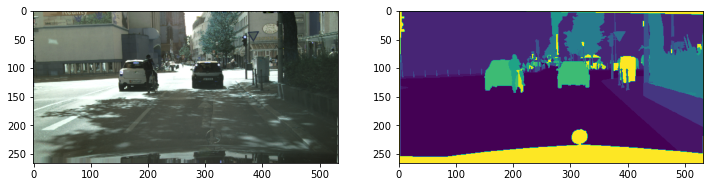

In [44]:
img = read_image(ds_val.imgs_files[10])
mask = read_image(ds_val.labels_files[10])
plot_two_imgs(img, mask[:,:,0])

In [45]:
x, y = ds_val[10]

In [46]:
x.shape

(3, 256, 512)

In [47]:
x1 = x[None,]
x1.shape

(1, 3, 256, 512)

In [48]:
y_hat = model(torch.FloatTensor(x1).cuda())
y_hat.shape

torch.Size([1, 20, 256, 512])

In [49]:
pred = torch.max(y_hat, 1)[1]
pred.shape

torch.Size([1, 256, 512])

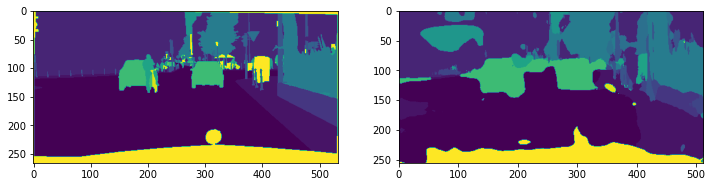

In [50]:
plot_two_imgs(mask[:,:,0], pred[0].cpu().numpy())

## Training with half precision
Here is the a tick to increase batch size and train faster.

In [52]:
from apex import amp

In [53]:
def valid_metrics_half(model, dl_valid):
    model.eval()
    batch_losses = []
    total = 0
    correct = 0
    for x, y in dl_valid:
        with torch.no_grad(): # reduces memory comsumption
            total += y.size(0)
            x = x.half().cuda()
            y = y.long().cuda()
            y_hat = model(x)
            loss = F.cross_entropy(y_hat, y, weight=class_weights)
            batch_losses.append(loss.item())
            pred = torch.max(y_hat, 1)[1]
            correct += (pred == y).float().sum().item()
            
    total *= y.size(1)*y.size(2) 
    return np.mean(batch_losses), correct/total

In [54]:
def train_epochs_half(model, optimizer, dl_train, dl_valid, epochs):
    batch_losses = []
    
    pbar = tqdm(total=epochs*len(dl_train))
    for epoch in range(epochs):
        best_val_loss, _ = valid_metrics_half(model, dl_valid)
        model.train()
        for x, y in dl_train:
            x = x.half().cuda()
            y = y.long().cuda()
            y_hat = model(x)
            loss = F.cross_entropy(y_hat, y, weight=class_weights)
            batch_losses.append(loss.item())
            
            optimizer.zero_grad() 
            #loss.backward()
            with amp.scale_loss(loss, optimizer) as scaled_loss:
                scaled_loss.backward()
            optimizer.step()
            pbar.update()
            
        train_loss = np.mean(batch_losses)
        val_loss, val_acc = valid_metrics_half(model, dl_valid)
        print ("train loss: %.3f val loss: %.3f val acc: %.3f" % (train_loss, val_loss, val_acc)) 
        
        # save the model weights to disk:
        if val_loss < best_val_loss:
            path = "{0}/models/model_half_{1:.0f}.pth".format(PATH, 100*val_acc)
            print(path)
            torch.save(model.state_dict(), path)
            best_val_loss = val_loss

In [55]:
dl_train = DataLoader(ds_train, batch_size=32, shuffle=True, num_workers=1)
dl_val = DataLoader(ds_val, batch_size=32, shuffle=False, num_workers=1)

In [99]:
model = unet().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0001)
model, optimizer = amp.initialize(model, optimizer, opt_level="O2", 
                                  keep_batchnorm_fp32=True, loss_scale="dynamic")

Selected optimization level O2:  FP16 training with FP32 batchnorm and FP32 master weights.

Defaults for this optimization level are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic


In [100]:
train_epochs_half(model, optimizer, dl_train, dl_val, epochs=10)

  0%|          | 0/930 [00:00<?, ?it/s]

train loss: 2.314 val loss: 2.149 val acc: 0.684
/data2/yinterian/cityscapes/models/model_half68.pth
train loss: 2.152 val loss: 2.017 val acc: 0.720
/data2/yinterian/cityscapes/models/model_half72.pth
train loss: 2.044 val loss: 1.835 val acc: 0.736
/data2/yinterian/cityscapes/models/model_half74.pth
train loss: 1.957 val loss: 1.865 val acc: 0.678
train loss: 1.886 val loss: 1.675 val acc: 0.760
/data2/yinterian/cityscapes/models/model_half76.pth
train loss: 1.823 val loss: 1.557 val acc: 0.768
/data2/yinterian/cityscapes/models/model_half77.pth
train loss: 1.766 val loss: 1.486 val acc: 0.765
/data2/yinterian/cityscapes/models/model_half76.pth
train loss: 1.715 val loss: 1.396 val acc: 0.770
/data2/yinterian/cityscapes/models/model_half77.pth
train loss: 1.666 val loss: 1.400 val acc: 0.757
train loss: 1.624 val loss: 1.347 val acc: 0.755
/data2/yinterian/cityscapes/models/model_half76.pth


In [101]:
train_epochs_half(model, optimizer, dl_train, dl_val, epochs=10)

  0%|          | 0/930 [00:00<?, ?it/s]

train loss: 1.205 val loss: 1.292 val acc: 0.794
/data2/yinterian/cityscapes/models/model_half79.pth
train loss: 1.179 val loss: 1.237 val acc: 0.776
/data2/yinterian/cityscapes/models/model_half78.pth
train loss: 1.156 val loss: 1.221 val acc: 0.770
/data2/yinterian/cityscapes/models/model_half77.pth
train loss: 1.139 val loss: 1.182 val acc: 0.801
/data2/yinterian/cityscapes/models/model_half80.pth
train loss: 1.121 val loss: 1.139 val acc: 0.785
/data2/yinterian/cityscapes/models/model_half79.pth
train loss: 1.105 val loss: 1.154 val acc: 0.781
train loss: 1.092 val loss: 1.076 val acc: 0.789
/data2/yinterian/cityscapes/models/model_half79.pth
train loss: 1.077 val loss: 1.017 val acc: 0.805
/data2/yinterian/cityscapes/models/model_half81.pth
train loss: 1.063 val loss: 1.024 val acc: 0.819
train loss: 1.049 val loss: 1.000 val acc: 0.792
/data2/yinterian/cityscapes/models/model_half79.pth


## Segmentation from pretrained models

In [56]:
from torchvision.models.segmentation.deeplabv3 import DeepLabHead
from torchvision import models


def createDeepLabv3(outputchannels=1):
    """DeepLabv3 class with custom head
    Args:
        outputchannels (int, optional): The number of output channels
        in your dataset masks. Defaults to 1.
    Returns:
        model: Returns the DeepLabv3 model with the ResNet101 backbone.
    """
    model = models.segmentation.deeplabv3_resnet101(pretrained=True,
                                                    progress=True)
    model.classifier = DeepLabHead(2048, outputchannels)
    # Set the model in training mode
    model.train()
    return model

In [57]:
model = createDeepLabv3(outputchannels=20)

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /home/yinterian/.cache/torch/hub/checkpoints/resnet101-5d3b4d8f.pth


  0%|          | 0.00/170M [00:00<?, ?B/s]

Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /home/yinterian/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

In [58]:
model = model.cuda()

In [59]:
dl_train = DataLoader(ds_train, batch_size=10, shuffle=True, num_workers=1)
dl_val = DataLoader(ds_val, batch_size=10, shuffle=False, num_workers=1)

In [60]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [62]:
x, y = next(iter(dl_train))

In [63]:
x = x.float().cuda()
y_hat = model(x)

In [65]:
y_hat.keys()

odict_keys(['out', 'aux'])

In [67]:
y_hat['out'].shape

torch.Size([10, 20, 256, 512])

In [74]:
train_epochs(model, optimizer, dl_train, dl_val, epochs=10, pretrained=True)

  0%|          | 0/2980 [00:00<?, ?it/s]

train loss: 1.146 val loss: 0.900 val acc: 0.806
/data2/yinterian/cityscapes/models/model_81.pth
train loss: 0.976 val loss: 0.761 val acc: 0.828
/data2/yinterian/cityscapes/models/model_83.pth
train loss: 0.888 val loss: 0.720 val acc: 0.835
/data2/yinterian/cityscapes/models/model_83.pth
train loss: 0.832 val loss: 0.702 val acc: 0.833
/data2/yinterian/cityscapes/models/model_83.pth
train loss: 0.789 val loss: 0.632 val acc: 0.844
/data2/yinterian/cityscapes/models/model_84.pth
train loss: 0.755 val loss: 0.623 val acc: 0.849
/data2/yinterian/cityscapes/models/model_85.pth
train loss: 0.729 val loss: 0.641 val acc: 0.845
train loss: 0.706 val loss: 0.614 val acc: 0.853
/data2/yinterian/cityscapes/models/model_85.pth
train loss: 0.687 val loss: 0.610 val acc: 0.852
/data2/yinterian/cityscapes/models/model_85.pth
train loss: 0.669 val loss: 0.636 val acc: 0.852
